# Prueba 3. Detección correcta de escala

## Inicialización FPGA

In [2]:
# Librería PYNQ
from pynq import Overlay, allocate
# Estructuras de datos y gráficos
import numpy as np
import matplotlib.pyplot as plt
# Librería MIDI
from mido import Message, MidiFile, MidiTrack, second2tick
# Librería lectura y creación de archivos de audio
from scipy.io import wavfile

In [3]:
# Controladores bloques de procesamiento
%run FFT_DMA_Driver.ipynb
%run Audio_DMA_Driver.ipynb
# Cargar Overlay FFT 
ol = Overlay('/home/xilinx/pynq/overlays/fft/disenofinal.bit')
# Inicializar DMAs, para enviar y recibir datos y configuración
fft = ol.fft_block
audio = ol.audio_block

## Carga de archivo de audio

In [4]:
# Cargar archivo de audio
SAMPLE_RATE, audio_data = wavfile.read("archivo1.wav")
print("Sample Rate: " + str(SAMPLE_RATE))

# Convertir a mono si es necesario
if len(audio_data.shape) > 1:
    audio_data = np.mean(audio_data, axis=1)
    
# Asegurarse de que el audio esté en formato float32
audio_data = audio_data.astype(np.float32)

# Normalizar el audio para la visualización
audio_data = audio_data / np.max(np.abs(audio_data))

Sample Rate: 44100


/usr/lib/python3/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


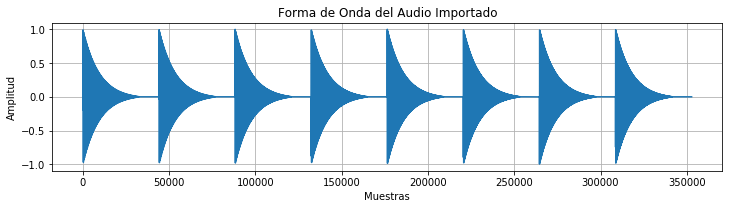

In [5]:
# Gráfica forma de onda
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_data)
plt.title("Forma de Onda del Audio Importado")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

## Definición de funciones a utilizar

## Configuración tamaño de bloque FFT

In [6]:
# Función para aplicar FFT
def apply_fft(input_data):
    """
    Aplica la Transformada Rápida de Fourier (FFT) a los datos de entrada.

    Parámetros:
    - input_data (numpy array): Datos de entrada en formato numpy array que se van a transformar.

    Devuelve:
    - Resultado de la aplicación de la FFT a los datos de entrada.
    """
    np.copyto(input_buffer_fft, input_data.astype(np.csingle))
    return fft.stream_fft(input_buffer_fft)

# Obtención de la frecuencia de mayor amplitud en cada bloque de la FFT
def get_max_amplitude_frequency(fft_result, sample_rate, max_frequency=5000):
    """
    Obtiene la frecuencia de mayor amplitud en un bloque de resultados de FFT.

    Parámetros:
    - fft_result (numpy array): Resultados de la FFT.
    - sample_rate (int): Tasa de muestreo de los datos originales.
    - max_frequency (float, opcional): Frecuencia máxima a considerar, por defecto es 5000 Hz.

    Devuelve:
    - frequency (float): Frecuencia con la mayor amplitud.
    - amplitude (float): Valor de la amplitud correspondiente a la frecuencia máxima.
    """
    # Calcular la magnitud de la FFT
    magnitudes = np.abs(fft_result)
    
    # Filtrar las frecuencias por debajo del umbral
    valid_indices = (frequencies_fft <= max_frequency)
    valid_magnitudes = magnitudes[valid_indices]
    
    # Si no hay frecuencias válidas, devolver None
    if len(valid_magnitudes) == 0:
        return 0, 0
    
    valid_frequencies = frequencies_fft[valid_indices]
    
    # Encontrar el índice de la magnitud máxima dentro de las frecuencias válidas
    max_index = np.argmax(valid_magnitudes)
    
    if abs(valid_frequencies[max_index]) > max_frequency:
        return 0, 0
    
    return abs(valid_frequencies[max_index]), valid_magnitudes[max_index]

# Función para convertir frecuencia a número de nota MIDI
def frequency_to_midi(frequency):
    """
    Convierte una frecuencia al número de nota MIDI correspondiente.

    Parámetros:
    - frequency (float): Frecuencia que se desea convertir.

    Devuelve:
    - midi_note (int): Número de nota MIDI correspondiente, o None si no se encuentra una nota correspondiente.
    """
    if frequency <= 0:
        return None

    if frequency <= 0:
        raise ValueError("Frequency must be positive.")
    
    # Buscar la nota MIDI correspondiente en el diccionario
    for midi_note, (low, mid, high) in midi_notes.items():
        if low <= frequency <= high:
            return midi_note
    
    # Si no se encuentra una nota correspondiente, devolver None
    return None

# Implementación https://github.com/NFJones/audio-to-midi/blob/master/audio_to_midi/notes.py
def generate_midi_notes():
    """
    Genera un diccionario de notas MIDI con sus correspondientes rangos de frecuencia.

    Parámetros:
    - Ninguno.

    Devuelve:
    - notes (dict): Diccionario donde las claves son los números de nota MIDI y los valores son listas con tres elementos 
    [low, mid, high] que representan el rango de frecuencias para cada nota MIDI.
    """

    # C0
    base = [7.946362749, 8.1757989155, 8.4188780665]
    
    # 12th root of 2
    multiplier = np.float_power(2.0, 1.0 / 12)

    notes = {0: base}
    for i in range(1, 128):
        mid = multiplier * notes[i - 1][1]
        low = (mid + notes[i - 1][1]) / 2.0
        high = (mid + (multiplier * mid)) / 2.0
        notes.update({i: [low, mid, high]})

    return notes

In [7]:
# Parámetros FFT y visualización
BLOCK_SIZE = 4096 # Cantidad de samples por cada bloque de audio
block_duration = BLOCK_SIZE / SAMPLE_RATE # Duración de cada bloque en segundos
frequencies_fft = np.fft.fftfreq(BLOCK_SIZE, d=1/SAMPLE_RATE) # Obtener las frecuencias correspondientes a cada índice

# Configurar FFT
fft.configure('1', BLOCK_SIZE)

# Buffer de entrada para DMA
input_buffer_fft = allocate(shape=(BLOCK_SIZE,), dtype=np.csingle)

# Generar el diccionario de frecuencias a notas MIDI
midi_notes = generate_midi_notes()

## Cálculo FFT archivo de audio con FPGA

In [8]:
%%time

fft_results = []
max_frequencies = []
max_magnitudes = []

# Dividir el audio en bloques y aplicar FFT
for start in range(0, len(audio_data), BLOCK_SIZE):
    block = audio_data[start:start + BLOCK_SIZE]
    if len(block) < BLOCK_SIZE:
        block = np.pad(block, (0, BLOCK_SIZE - len(block)), 'constant')
    res_fft = apply_fft(block)
    
    fft_results.append(res_fft)
    
    # Obtener la frecuencia de mayor amplitud y su magnitud
    frequency, magnitude = get_max_amplitude_frequency(res_fft, SAMPLE_RATE, 5000)
    max_frequencies.append(frequency)
    max_magnitudes.append(magnitude)

CPU times: user 288 ms, sys: 0 ns, total: 288 ms
Wall time: 296 ms


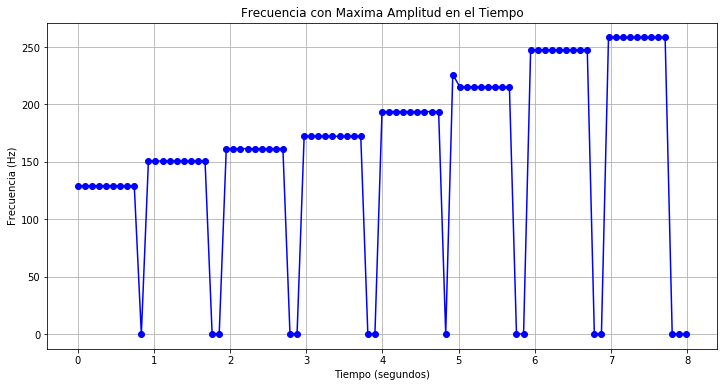

In [9]:
# Calcular el tiempo en segundos para cada bloque
block_times = [i * (block_duration) for i in range(len(max_frequencies))]

# Gráfico visualización de frecuencias en tiempo
plt.figure(figsize=(12, 6))
plt.plot(block_times, max_frequencies, marker='o', linestyle='-', color='b')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia (Hz)')
plt.title('Frecuencia con Maxima Amplitud en el Tiempo')
plt.grid(True)

# Mostrar el gráfico
plt.show()

# Identificar escala musical

## Creación archivo MIDI a partir de frecuencias FFT

In [11]:
# Crear un nuevo archivo MIDI
midi = MidiFile()
track = MidiTrack()
midi.tracks.append(track)
midi_notes_scale = []

# Ajustar el tempo (120 BPM por defecto)
tempo = 500000  # Microsegundos por beat para 120 BPM

# Añadir las notas al track
last_note = None
last_tick = 0

for i, (time, frequency) in enumerate(zip(block_times, max_frequencies)):
    # Convertir la frecuencia a número de nota MIDI
    midi_note = frequency_to_midi(frequency)
    if midi_note != None:
        midi_notes_scale.append(midi_note)
    
    if midi_note is None:
        # Apagar la nota anterior si hay una
        if last_note is not None:
            track.append(Message('note_off', note=last_note, velocity=64, time=delta_time))
            last_note = None
            last_tick = current_tick
    else:
        # Asegurarse de que la nota esté en el rango válido (21-108 para piano)
        if 21 <= midi_note <= 200:
            # Calcular el tiempo en ticks desde el inicio
            current_tick = int(second2tick(time, midi.ticks_per_beat, tempo))
            delta_time = current_tick - last_tick

            # Si hay una nota anterior y es diferente a la actual, apagarla
            if last_note is not None and last_note != midi_note:
                track.append(Message('note_off', note=last_note, velocity=64, time=delta_time))
                delta_time = 0  # Reset delta time for note_on

            # Encender la nueva nota
            if last_note != midi_note:
                track.append(Message('note_on', note=midi_note, velocity=64, time=delta_time))
                last_note = midi_note
                last_tick = current_tick

# Asegurar que la última nota se apague
if last_note is not None:
    end_tick = int(second2tick(block_times[-1] + block_duration, midi.ticks_per_beat, tempo))
    delta_time = end_tick - last_tick
    track.append(Message('note_off', note=last_note, velocity=64, time=delta_time))

# Guardar el archivo MIDI
midi.save('output_midi.mid')
print("Archivo MIDI creado y guardado como 'output_midi.mid'.")

Archivo MIDI creado y guardado como 'output_midi.mid'.


## Funciones identificación

In [12]:
def normalize_notes(midi_notes):
    """
    Traspone las notas MIDI a una sola octava.

    Parámetros:
    - midi_notes (dict): Diccionario MIDI de las notas calculadas.

    Devuelve:
    - notes (dict): Diccionario de notas MIDI traspuestas a una escala.
    """    
    return [note % 12 for note in midi_notes]

def identify_scales(midi_notes):
    """
    Identifica todas las escalas que coincidan con un conjunto de notas musicales en MIDI.

    Parámetros:
    - midi_notes (list): Lista de notas MIDI calculadas.

    Devuelve:
    - matched_scales (list): Lista de escalas que coinciden completamente con las notas MIDI.
    """
    # Escalas comunes
    scales = {
        'Mayor': [0, 2, 4, 5, 7, 9, 11],
        'Menor Natural': [0, 2, 3, 5, 7, 8, 10],
        'Menor Harmónica': [0, 2, 3, 5, 7, 8, 11],
        'Menor Melódica': [0, 2, 3, 5, 7, 9, 11],
        'Mayor Pentatónica': [0, 2, 4, 7, 9],
        'Menor Pentatónica': [0, 3, 5, 7, 10]
    }
    
    # Nombre de notas para identificar escala
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    # Normalizar notas
    normalized_notes = set(normalize_notes(midi_notes))
    normalized_notes_names = [note_names[note] for note in normalized_notes]
    
    print(f'Notas detectadas: {normalized_notes_names}')

    # Comparar notas normalizadas a cada escala
    matched_scales = []
    best_match_count = 0
    least_missing_count = float('inf')

    # Comprobar las escalas en todas las posibles notas
    for scale_name, scale_pattern in scales.items():
        for transposition in range(12):
            transposed_pattern = [(note + transposition) % 12 for note in scale_pattern]
            if normalized_notes == set(transposed_pattern):
                matched_scales.append((f'{note_names[transposition]} {scale_name}', [note_names[trans_note] for trans_note in transposed_pattern]))
                
    if len(matched_scales) <= 0:
        print("No se han encontrado matches.")
                    
    return matched_scales

matched_scales = identify_scales(midi_notes_scale)

for scale_info in matched_scales:
    scale_name, pattern = scale_info
    print(f'La escala identificada es: {scale_name}')
    print(f'El patrón de la escala es: {pattern}')
    print('---')

Notas detectadas: ['C', 'D', 'E', 'F', 'G', 'A', 'B']
La escala identificada es: C Mayor
El patrón de la escala es: ['C', 'D', 'E', 'F', 'G', 'A', 'B']
---
La escala identificada es: A Menor Natural
El patrón de la escala es: ['A', 'B', 'C', 'D', 'E', 'F', 'G']
---


## Set pruebas identificación de escala

In [13]:
casos_de_prueba = [
    {
        "nombre": "Do Mayor",
        "entrada": [60, 62, 64, 65, 67, 69, 71],  # C, D, E, F, G, A, B
        "escalas_esperadas": ["C Mayor"]
    },
    {
        "nombre": "La Menor Natural",
        "entrada": [57, 59, 60, 62, 64, 65, 67],  # A, B, C, D, E, F, G
        "escalas_esperadas": ["A Menor Natural"]
    },
    {
        "nombre": "Sol Mayor Pentatónica",
        "entrada": [55, 57, 59, 62, 64],  # G, A, B, D, E
        "escalas_esperadas": ["G Mayor Pentatónica"]
    },
    {
        "nombre": "Notas sin coincidencia",
        "entrada": [60, 61, 64, 62, 63, 65, 67, 68, 70],  # C, C#, E, D, D#, F, G, G#, A#
        "escalas_esperadas": []  # No debería coincidir con ninguna escala
    }
]

for caso in casos_de_prueba:
    print("========================================================")
    escalas_identificadas = identify_scales(caso["entrada"])
    escalas_identificadas_nombres = [scale_name for scale_name, pattern in escalas_identificadas]

    if all(escala in escalas_identificadas_nombres for escala in caso["escalas_esperadas"]):
        print(f'Prueba {caso["nombre"]} pasada.')
    else:
        print(f'Prueba {caso["nombre"]} fallida: se esperaban {caso["escalas_esperadas"]}, pero se obtuvieron {escalas_identificadas}')


Notas detectadas: ['C', 'D', 'E', 'F', 'G', 'A', 'B']
Prueba Do Mayor pasada.
Notas detectadas: ['C', 'D', 'E', 'F', 'G', 'A', 'B']
Prueba La Menor Natural pasada.
Notas detectadas: ['D', 'E', 'G', 'A', 'B']
Prueba Sol Mayor Pentatónica pasada.
Notas detectadas: ['C', 'C#', 'D', 'D#', 'E', 'F', 'G', 'G#', 'A#']
No se han encontrado matches.
Prueba Notas sin coincidencia pasada.
